<a href="https://colab.research.google.com/github/danya-pixel/cv-skoltech-course/blob/main/CV_Intro_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune YOLOv8 from Grounding DINO

<div align="center">

  <a href="https://ultralytics.com/yolov8" target="_blank">
    <img width="1024", src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png"></a>


<br>
  <a href="https://console.paperspace.com/github/ultralytics/ultralytics"><img src="https://assets.paperspace.io/img/gradient-badge.svg" alt="Run on Gradient"/></a>
  <a href="https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
  <a href="https://www.kaggle.com/ultralytics/yolov8"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"></a>
<br>

Welcome to the Ultralytics YOLOv8 🚀 notebook! <a href="https://github.com/ultralytics/ultralytics">YOLOv8</a> is the latest version of the YOLO (You Only Look Once) AI models developed by <a href="https://ultralytics.com">Ultralytics</a>. This notebook serves as the starting point for exploring the various resources available to help you get started with YOLOv8 and understand its features and capabilities.

YOLOv8 models are fast, accurate, and easy to use, making them ideal for various object detection and image segmentation tasks. They can be trained on large datasets and run on diverse hardware platforms, from CPUs to GPUs.

We hope that the resources in this notebook will help you get the most out of YOLOv8. Please browse the YOLOv8 <a href="https://docs.ultralytics.com/">Docs</a> for details, raise an issue on <a href="https://github.com/ultralytics/ultralytics">GitHub</a> for support, and join our <a href="https://ultralytics.com/discord">Discord</a> community for questions and discussions!

</div>

## 1. Setup

Based on [medium](https://medium.com/@yongsun.yoon/fine-tuning-yolov8-using-custom-dataset-generated-by-open-world-object-detector-5724e267645d).



In traditional object detection, models are trained to detect objects from a predefined set of categories. Open-world (also called as open-vocabulary or open-set) object detection aims to solve this problem by allowing models to detect arbitrary classes.

Many open-world object detectors leverage vision-language multi-modal training, allowing them to detect the objects of classes that written in human text by fusing the representations of image and language.

______________


Unfortunately, the large size of open-world object detectors makes it difficult to use it in low-resource environments. If we want to detect fixed set of classes (but not included in the benchmark datasets), we can use them as dataset labelers. By fine-tuning small object detection models, such as YOLO, with the generated dataset, we can obtain custom and efficient object detector.


In [ ]:
# setup GroundingDINO
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO
!pip install -q -e .
%cd ..
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [ ]:
!pip install -q ultralytics datasets


In [2]:
import sys
sys.path.append('GroundingDINO')

In [1]:
import os
import yaml
import numpy as np
import supervision as sv
from PIL import Image
from tqdm.auto import tqdm
from ultralytics import YOLO
from datasets import load_dataset
from groundingdino.util.inference import load_model, load_image, predict, annotate

/home/danya-sakharov/cv-skoltech-course/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Grounding DINO

### Custom Dataset Generation by Open-world Object Detector

To train new class to pretrained object detector, we can chose “food” class and Grounding DINO for open-world object detection. GroundingDINO extends a closed-set detector DINO by performing vision-language modality fusion at multiple phases.

The framework of Grounding DINO is presented below.

<div align="center">

  <a href="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1byo0nLGRhAZln508M3abw.png" target="_blank">
    <img width="1024", src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1byo0nLGRhAZln508M3abw.png"></a>

In [2]:
def run_dino(dino, image, text_prompt='helmet', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino,
        image = image,
        caption = text_prompt,
        box_threshold = box_threshold,
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

In [7]:
dino = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


final text_encoder_type: bert-base-uncased


## 3. Annotate Dataset

In [16]:
def annotate(dino, data, data_size, data_dir, text_prompt):
    data = data.train_test_split(train_size=min(len(data), data_size))['train']

    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i, d in enumerate(tqdm(data)):
        image_path = f'{image_dir}/{i:06d}.png'
        label_path = f'{label_dir}/{i:06d}.txt'
        image = d['image'].resize((640, 640))
        image.save(image_path)

        image_source, image = load_image(image_path)
        boxes, logits, phrases = run_dino(dino, image, text_prompt=text_prompt)

        label = ['0 ' + ' '.join(list(map(str, b))) for b in boxes.tolist()]
        label = '\n'.join(label)
        with open(label_path, 'w') as f:
            f.write(label)

Я решил попробовать провести fine-tune на датасете для детекции шлемов с huggingface. https://huggingface.co/datasets/pzalavad/HelmetDataset

In [13]:
data = load_dataset('pzalavad/HelmetDataset')

Generating test split: 100%|██████████| 107/107 [00:00<00:00, 60606.42 examples/s]


In [14]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2193
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 209
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 107
    })
})

In [17]:
annotate(dino, data['train'], 500, 'data/train', text_prompt="helmet")
annotate(dino, data['validation'], 20, 'data/valid', text_prompt="helmet")

  0%|          | 0/500 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
None of the inputs have requires_grad=True. Gradients will be None
100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


In [18]:
config = {
    'names': ['helmet'],
    'nc': 1,
    'train': 'train/images',
    'val': 'valid/images'
}

with open('data/data.yaml', 'w') as f:
    yaml.dump(config, f)

## 4. Fine-tune YOLOv8
### Fine-tune on helmets

In [3]:
yolo = YOLO('yolov8n.pt')

In [41]:
yolo.train(data='data/data.yaml', epochs=5)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.9 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24248MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

val: Scanning /home/danya-sakharov/datasets/data/valid/labels.cache... 20 images, 10 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Plotting labels to /home/danya-sakharov/cv-skoltech-course/runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/danya-sakharov/cv-skoltech-course/runs/detect/train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/5      2.88G     0.9575      2.793      1.317          6        640: 100%|██████████| 32/32 [00:02<00:00, 15.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]
                   all         20         17    0.00217      0.765       0.28      0.131

      Epoch    GPU_mem   bo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f277c17d480>
fitness: 0.399381886075527
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.37354])
names: {0: 'helmet'}
plot: True
results_dict: {'metrics/precision(B)': 0.6918691488227912, 'metrics/recall(B)': 0.5284056943581681, 'metrics/mAP50(B)': 0.6319482461212471, 'metrics/mAP50-95(B)': 0.3735411794037803, 'fitness': 0.399381886075527}
save_dir: PosixPath('/home/danya-sakharov/cv-skoltech-course/runs/detect/train6')
speed: {'preprocess': 0.4941940307617188, 'inference': 0.5500197410583496, 'loss': 0.0003337860107421875, 'postprocess': 0.5670905113220215}

In [7]:
valid_results = yolo.val()
print(valid_results)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.9 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24248MiB)
val: Scanning /home/danya-sakharov/datasets/data/valid/labels.cache... 20 images, 10 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]
                   all         20         17      0.671      0.719      0.704      0.463
Speed: 3.4ms preprocess, 5.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /home/danya-sakharov/cv-skoltech-course/runs/detect/val4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1d08502110>
fitness: 0.4870112200021598
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.46288])
names: {0: 'helmet'}
plot: True
results_dict: {'metrics/precision(B)': 0.67068405769467, 'metrics/recall(B)': 0.7193524287409525, 'metrics/mAP50(B)': 0.7041997130676761, 'metrics/mAP50-95(B)': 0.4628791652171024, 'fitness': 0.4870112200021598}
save_dir: PosixPath('/home/danya-sakharov/cv-skoltech-course/runs/detect/val4')
speed: {'preprocess': 3.3834457397460938, 'inference': 5.71141242980957, 'loss': 0.0010132789611816406, 'postprocess': 0.7991909980773926}


Precision, recall и mAP50 в районе 0.7, что неплохой результат (однако не идеальный). Пробовал запустить несколько ранов по разному колчисетву эпох, лучшим получился 4й с изначальным количеством эпох = 5. 

## 5. Test fine-tuned YOLOv8

In [2]:
def run_yolo(yolo, image_url, conf=0.25, iou=0.7):
    results = yolo(image_url, conf=conf, iou=iou)
    res = results[0].plot()[:, :, [2,1,0]]
    return Image.fromarray(res)

In [3]:
yolo = YOLO('runs/detect/train4/weights/best.pt')

Взял несколько картинок людей на мотоциклах с интернета (не из датасета)


image 1/1 /home/danya-sakharov/cv-skoltech-course/helmet/test/images/3.jpg: 640x640 1 helmet, 7.6ms
Speed: 4.4ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


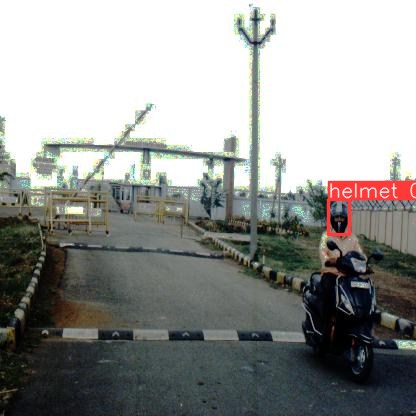

In [33]:
image_url = 'helmet/test/images/3.jpg'
run_yolo(yolo, image_url)


image 1/1 /home/danya-sakharov/cv-skoltech-course/1.jpg: 448x640 1 helmet, 36.3ms
Speed: 3.0ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


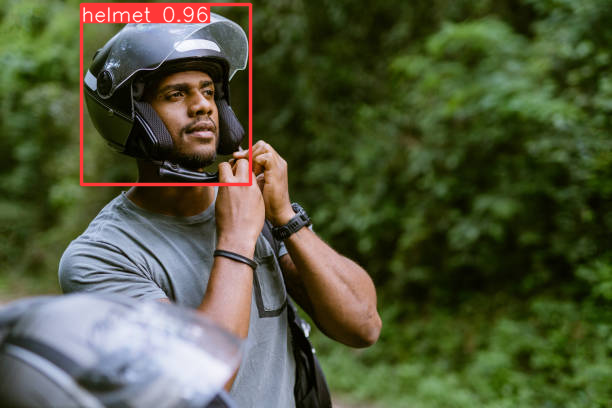

In [4]:
# run_yolo(yolo, "https://nox-helmet.com/wp-content/uploads/2023/01/JET-2023.jpg")
run_yolo(yolo, "1.jpg")



image 1/1 /home/danya-sakharov/cv-skoltech-course/2.jpeg: 640x448 4 helmets, 61.1ms
Speed: 5.2ms preprocess, 61.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


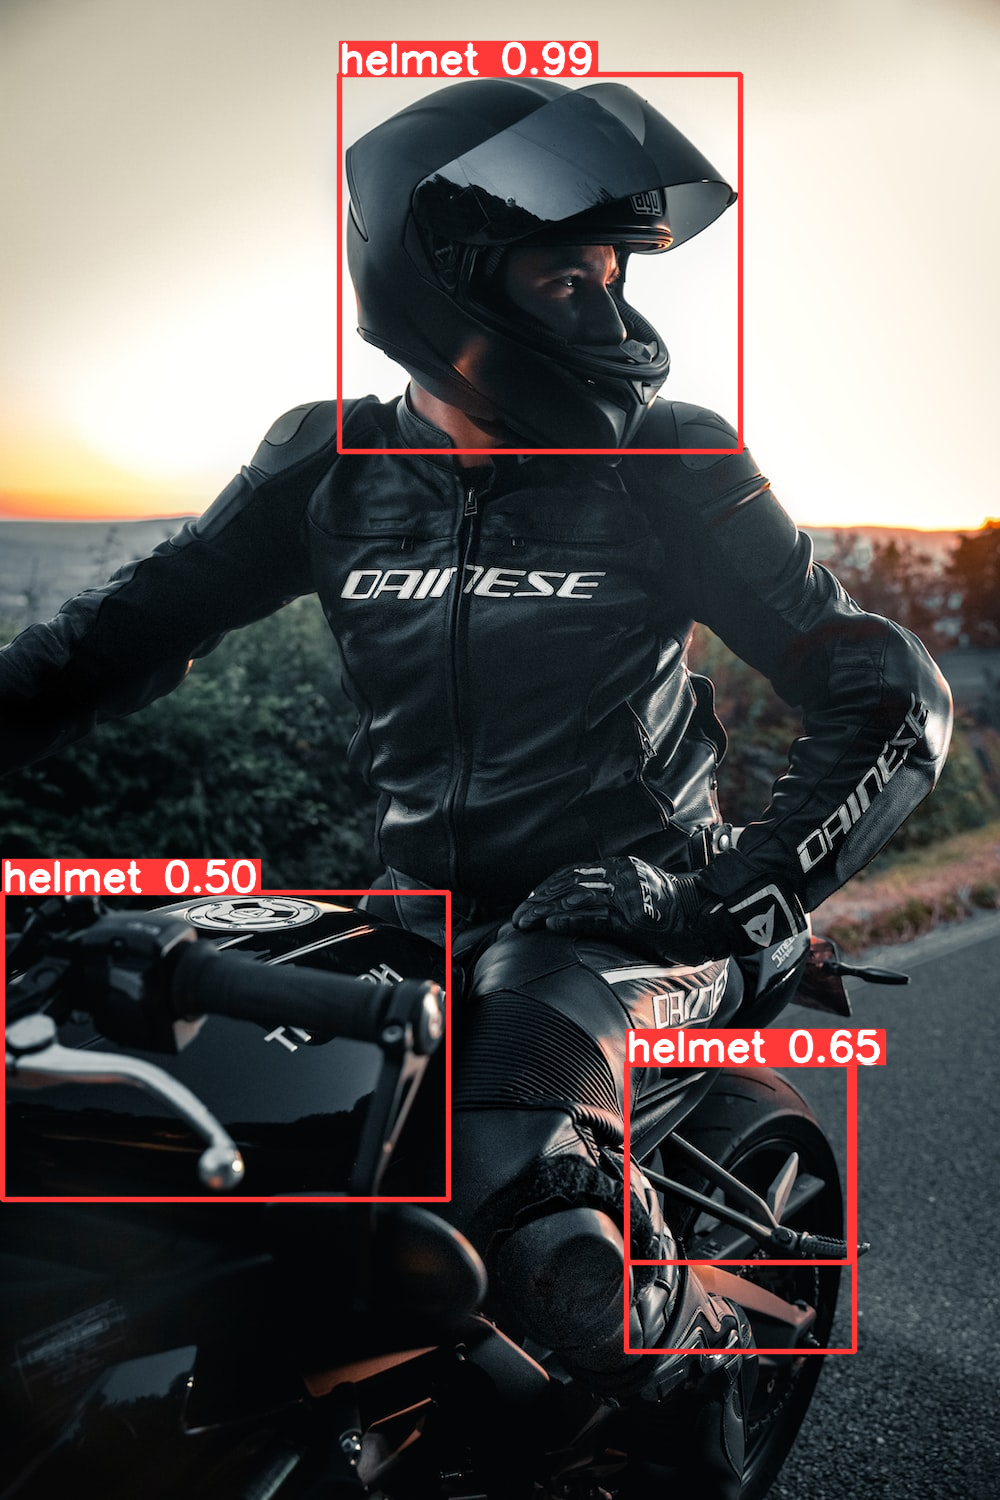

In [6]:
run_yolo(yolo, "2.jpeg")


Немного странно, что как шлем отметилась часть мотоцикла. Возможно, результаты далеки от идеальных из-за того, что нужно получше подобрать гиперпараметры и трэшхолды.  